In [4]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import learning_curve, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    if 'total' in dfX.columns:
        dfX.drop('total', axis=1, inplace=True)
        r_dfY = dfXY.loc[:, lbls[0]]
        c_dfY = dfXY.loc[:, lbls[1]]
        e_dfY = dfXY.loc[:, lbls[2]]
        b_dfY = dfXY.loc[:, lbls[3]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY

In [5]:
#trainset1 = '../2jul2018_testset1_nucs_fissact_not-scaled.pkl'
trainset2 = '../../prep-pkls/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
#trainXY1 = pd.read_pickle(trainset1)
trainXY2 = pd.read_pickle(trainset2)
#trainX1, rY1, cY1, eY1, bY1 = splitXY(trainXY1)
trainX2, rY2, cY2, eY2, bY2 = splitXY(trainXY2)
#trainX2 = scale(trainX2)

In [6]:
trainX2.shape

(24795, 15)

In [103]:
scale = StandardScaler()
trainX2 = scale.fit(trainX2).transform(trainX2)

In [105]:
scale.mean_
scale.var_

array([2.63548254e+01, 2.35684218e+01, 1.74328134e+01, 2.33104703e-02,
       1.61377473e+01, 3.17953674e+00, 2.18675029e+01, 2.17230695e+01,
       2.74492883e+01, 1.43147133e+01, 1.91236962e+01, 2.17747337e+01,
       3.36732771e+00, 3.39631319e+01, 4.45917518e+00, 8.41317218e+00,
       1.30225624e+00, 8.00794822e+00, 7.74330483e+00, 1.71423208e+01,
       2.42754193e+01, 2.81820116e+00, 8.30324147e+00, 7.62703235e+00,
       1.73215465e-02, 3.79634264e+00, 1.81340046e+01, 2.48414299e+01,
       1.53720251e+01, 2.75476186e+00, 5.49902594e+00, 1.50522722e+01,
       7.46735552e-02, 1.03467662e+03, 1.73385095e+01, 4.49457824e+03,
       2.25351895e-02, 3.08400280e+01, 3.92240512e+01, 9.47995819e+01,
       4.84879969e+00, 8.45089517e+00, 1.03724634e+01, 1.31147087e+01,
       1.60573928e+01, 1.86354280e+01])

In [97]:
print(trainXY1.shape)
print(trainXY2.shape)

(1966, 47)
(10287, 52)


In [106]:
trainX2
#pd.DataFrame(trainX2)

array([[-1.74036092, -1.71718002, -1.77359636, ..., -1.89849363,
        -1.84512213, -1.80261662],
       [-1.56368506, -1.57616296, -1.58639853, ..., -1.66930199,
        -1.63205393, -1.60578452],
       [-1.56360715, -1.56543117, -1.58620692, ..., -1.66792132,
        -1.63202897, -1.60578452],
       ...,
       [-1.12111885, -1.08995692, -1.11806864, ..., -1.09936038,
        -1.10295203, -1.11878895],
       [-1.12111885, -1.08542526, -1.11806864, ..., -1.09936038,
        -1.10295203, -1.11878895],
       [-1.12111885, -1.08542526, -1.11806864, ..., -1.09936038,
        -1.10295203, -1.11878895]])

In [29]:
extra = []
for i in trainX2:
    if i not in trainX1:
        extra.append(i)
extra

['cs135', 'pd104', 'pd105', 'pd106', 'pu242']

In [107]:
dtr = DecisionTreeRegressor()
dtr

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [108]:

dtr.fit(trainX2, cY2)
cv_scr = cross_val_score(dtr, trainX2, cY2, cv=5)

In [109]:
scr = cv_scr
fi = dtr.feature_importances_
print(scr)

[0.97674601 0.97326819 0.74433583 0.96823127 0.72539757]


In [110]:
features  = list(zip(trainX2.columns, fi))
features.sort(key=lambda x: x[1])
#features

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [123]:
dtr.tree_.max_depth

84

In [112]:
trainset_frac = np.array( [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0] )
tsize, train, cv = learning_curve(dtr, trainX2, cY2, train_sizes=trainset_frac, cv=8, shuffle=True)

In [113]:
train_mean = np.mean(train, axis=1)
cv_mean = np.mean(cv, axis=1)

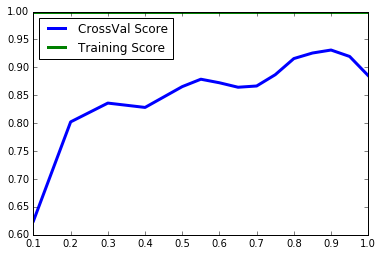

In [114]:
lc = pd.DataFrame({'Training Score' : train_mean, 'CrossVal Score' : cv_mean}, index=trainset_frac)
plt.figure()
lc.plot(linewidth=3)

In [125]:
dtr_grid = {"max_depth": np.linspace(3, 90).astype(int), "max_features": np.linspace(5, len(trainXY2.columns)-6).astype(int)}

In [126]:
alg1_opt = RandomizedSearchCV(estimator=dtr, param_distributions=dtr_grid, n_iter=20, scoring='explained_variance', n_jobs=-1, cv=5, return_train_score=True)
alg1_opt.fit(trainX2, cY2)
d1 = alg1_opt.best_params_['max_depth']
f1 = alg1_opt.best_params_['max_features']
print(d1, f1)

74 38


In [131]:
dtr.feature_importances_

array([9.62243477e-04, 1.66076484e-05, 2.70083386e-04, 1.02640550e-02,
       1.22107888e-02, 2.68016187e-02, 6.20004963e-02, 1.42686910e-05,
       2.90246661e-17, 7.57370579e-03, 3.40558983e-07, 3.47471718e-04,
       1.94358600e-03, 1.32205256e-01, 4.27789560e-05, 1.63423691e-06,
       2.91288676e-17, 1.61573503e-06, 3.08676025e-01, 2.67337883e-05,
       2.99067837e-03, 1.69369550e-02, 5.15618903e-02, 3.57188082e-03,
       0.00000000e+00, 1.67771670e-02, 2.58979453e-08, 3.76851142e-03,
       1.94086419e-02, 4.58587036e-09, 3.01923205e-01, 1.66818170e-07,
       1.27333089e-03, 1.34210409e-03, 1.96102184e-05, 3.71351910e-08,
       3.47952767e-07, 2.17747592e-06, 6.23564367e-09, 8.89687981e-05,
       6.08840642e-05, 4.38084138e-07, 1.37576104e-08, 2.51284154e-04,
       6.11449356e-09, 1.66623547e-02])

In [26]:
alg1_init = alg1_opt.best_estimator_

In [27]:
k

,AbsTrainSize,CV-Score,TrainScore,Algorithm
0.10,131,0.795065,0.870229,knn
0.20,262,0.849952,0.921120,knn
0.30,393,0.892716,0.938083,knn
0.40,524,0.891705,0.943384,knn
0.50,655,0.903410,0.954198,knn
0.55,720,0.906457,0.954167,knn
0.60,786,0.907478,0.958863,knn
0.65,851,0.906467,0.961614,knn
0.70,916,0.906462,0.964702,knn
0.75,982,0.911038,0.964698,knn
